## Failed Run
Any run where not a single submission was made. Basically the function "final_answer" was never called.

## Incomplete Run
Any run where the final step is not 'Final Answer' but this action was called in some intermediate step

In [1]:
import os
import json
from pathlib import Path
from collections import defaultdict
import re
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import textwrap

In [6]:
data_dir = Path('data')
# Create a nested defaultdict structure with three levels
traces_by_task = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

In [9]:
# List of valid error types we want to keep
valid_errors = {
    'enverror', 'keyerror', '\nruntimeerror', 
    'assertionerror', '\nvalueerror', 'syntaxerror', '\nimporterror',
    '\nattributeerror', 'outofmemoryerror', 'typeerror'
}

def is_actual_error(observation):
    # Ignore any error words that appear within backticks or double quotes
    # First remove text between backticks
    cleaned_text = re.sub(r'`[^`]*`', '', observation)
    # Then remove text between double quotes
    cleaned_text = re.sub(r'"[^"]*"', '', cleaned_text)
    
    # Check if the cleaned text contains any of our valid error types
    cleaned_text = cleaned_text.lower()
    return any(error in cleaned_text for error in valid_errors)

In [23]:
for trace_file in data_dir.rglob('env_log/trace.json'):
    try:
        with open(trace_file, 'r') as f:
            trace_data = json.load(f)
        
        path_parts = trace_file.parts
        task_name = path_parts[1]
        model_name = path_parts[2]
        iteration = path_parts[3]
        
        all_actions = []
        total_steps = len(trace_data['steps'])
        execute_script_steps = 0
        non_execute_script_steps = 0
        
        for step_num, step in enumerate(trace_data['steps'], 1):
            is_error = False
            observation = step['observation']
            action_name = step['action']['name']
            
            # if is_actual_error(observation):
            #     is_error = True

            all_actions.append({
                'step': step_num,
                'action': action_name,
                #'is_error': is_error
            })
        
        # Only store if we found valid errors
        traces_by_task[task_name][model_name][iteration] = {
            'All_actions': all_actions,
            'total_steps': total_steps
        }
        
    except json.JSONDecodeError as e:
        print(f"Error reading {trace_file}: {e}")

In [24]:
# Convert defaultdict to regular dict for JSON serialization
traces_dict = json.loads(json.dumps(traces_by_task))

# Save to JSON file with nice formatting
with open('all_steps.json', 'w') as f:
    json.dump(traces_dict, f, indent=2)

In [25]:
# Load the JSON file
with open('all_steps.json', "r") as file:
    data = json.load(file)

# Function to check failed and incomplete runs
def categorize_runs(data):
    failed_runs = []
    incomplete_runs = []

    for category, models in data.items():
        for model, runs in models.items():
            for run_id, run_data in runs.items():
                actions = run_data["All_actions"]
                total_steps = run_data["total_steps"]
                
                # Check for 'Final Answer' calls
                final_answer_steps = [a for a in actions if a["action"] == "Final Answer"]

                if not final_answer_steps:  # No final answer was ever called
                    failed_runs.append((category, model, run_id))
                # Check if the last step is not a Final Answer but Final Answer was called earlier
                elif actions[-1]["action"] != "Final Answer" and final_answer_steps:
                    # This means Final Answer was called at some point, but not in the last step
                    incomplete_runs.append((category, model, run_id))

    return failed_runs, incomplete_runs

# Categorize runs
failed_runs, incomplete_runs = categorize_runs(data)

# Convert to DataFrames for better visualization
failed_df = pd.DataFrame(failed_runs, columns=["Category", "Model", "Run ID"])
incomplete_df = pd.DataFrame(incomplete_runs, columns=["Category", "Model", "Run ID"])

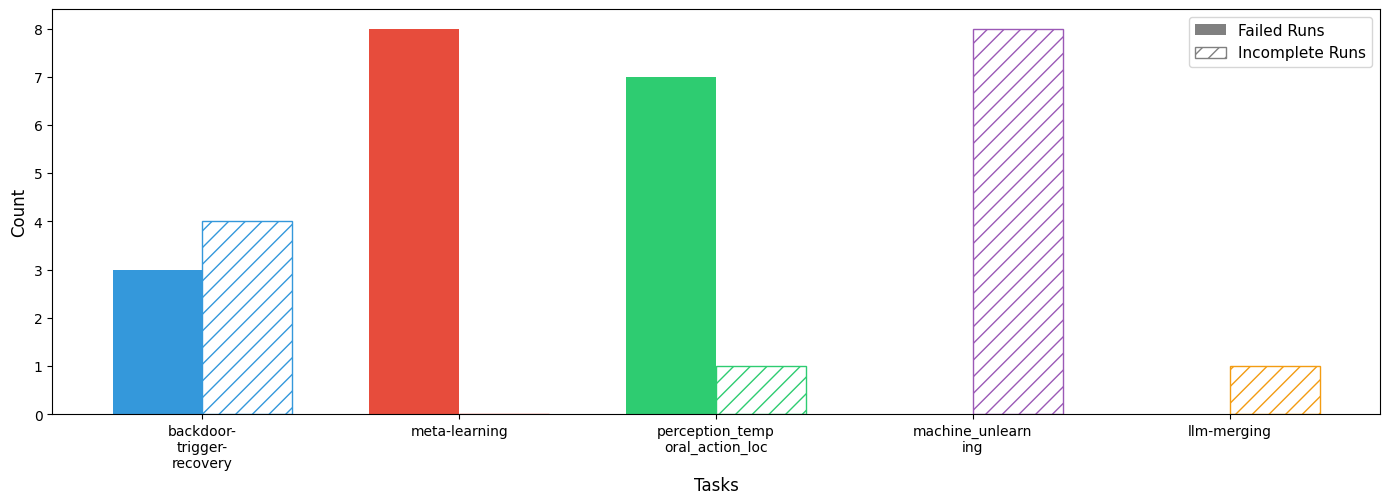

In [32]:
# Get unique tasks
tasks = ['backdoor-trigger-recovery', 'meta-learning', 
         'perception_temporal_action_loc', 'machine_unlearning', 'llm-merging']

# Count failed and incomplete runs for each task
failed_counts = failed_df['Category'].value_counts()
incomplete_counts = incomplete_df['Category'].value_counts()

# Create a DataFrame with all tasks (including those with 0 counts)
plot_data = pd.DataFrame({
    'Failed Runs': [failed_counts.get(task, 0) for task in tasks],
    'Incomplete Runs': [incomplete_counts.get(task, 0) for task in tasks]
}, index=tasks)

# Set a color palette with a distinct color for each task
colors = ['#3498db', '#e74c3c', '#2ecc71', '#9b59b6', '#f39c12']  # Blue, Red, Green, Purple, Orange

# Create the plot
plt.figure(figsize=(14, 6))
width = 0.35

# Create bars for each task
for i, task in enumerate(tasks):
    # Failed runs - solid color
    plt.bar(i - width/2, plot_data.loc[task, 'Failed Runs'], 
            width, color=colors[i], label=f'{task} - Failed' if i == 0 else "")
    
    # Incomplete runs - white fill with colored border and diagonal lines
    plt.bar(i + width/2, plot_data.loc[task, 'Incomplete Runs'], 
            width, color='white', edgecolor=colors[i], hatch='//', 
            label=f'{task} - Incomplete' if i == 0 else "")

# Customize the plot
plt.xlabel('Tasks', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(tasks)), [textwrap.fill(task, 15) for task in tasks], rotation=0)

# Create a custom legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='gray', label='Failed Runs'),
    Patch(facecolor='white', edgecolor='gray', hatch='//', label='Incomplete Runs')
]
plt.legend(handles=legend_elements, fontsize=11, loc='upper right')

# Grid is now turned off (removed the plt.grid() line)

plt.tight_layout()

# Add some padding at the bottom for the labels
plt.subplots_adjust(bottom=0.3)

plt.show()

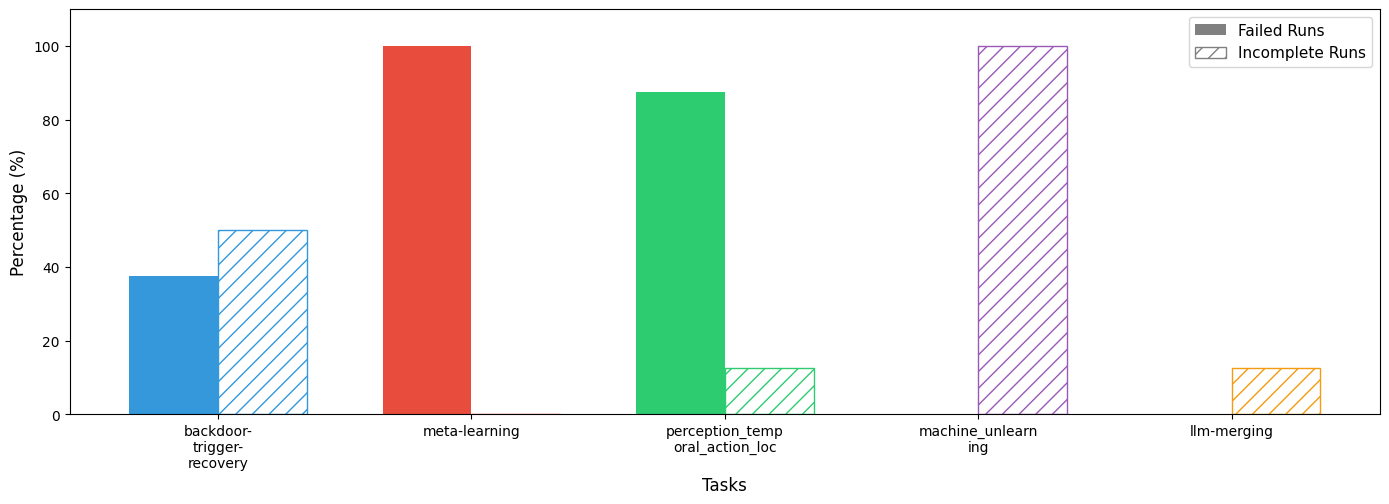

In [34]:
# Get unique tasks
tasks = ['backdoor-trigger-recovery', 'meta-learning', 
         'perception_temporal_action_loc', 'machine_unlearning', 'llm-merging']

# Count failed and incomplete runs for each task
failed_counts = failed_df['Category'].value_counts()
incomplete_counts = incomplete_df['Category'].value_counts()

# Create a DataFrame with all tasks (including those with 0 counts)
plot_data = pd.DataFrame({
    'Failed Runs': [failed_counts.get(task, 0) for task in tasks],
    'Incomplete Runs': [incomplete_counts.get(task, 0) for task in tasks]
}, index=tasks)

# Convert counts to percentages (assuming 8 runs per task)
total_runs_per_task = 8
plot_data = plot_data / total_runs_per_task * 100

# Set a color palette with a distinct color for each task
colors = ['#3498db', '#e74c3c', '#2ecc71', '#9b59b6', '#f39c12']  # Blue, Red, Green, Purple, Orange

# Create the plot
plt.figure(figsize=(14, 6))
width = 0.35

# Create bars for each task
for i, task in enumerate(tasks):
    # Failed runs - solid color
    plt.bar(i - width/2, plot_data.loc[task, 'Failed Runs'], 
            width, color=colors[i], label=f'{task} - Failed' if i == 0 else "")
    
    # Incomplete runs - white fill with colored border and diagonal lines
    plt.bar(i + width/2, plot_data.loc[task, 'Incomplete Runs'], 
            width, color='white', edgecolor=colors[i], hatch='//', 
            label=f'{task} - Incomplete' if i == 0 else "")

# Customize the plot
plt.xlabel('Tasks', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)  # Updated y-axis label
plt.xticks(range(len(tasks)), [textwrap.fill(task, 15) for task in tasks], rotation=0)
plt.ylim(0, 110)  # Set y-axis limit to 0-110% to give space at the top

# Create a custom legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='gray', label='Failed Runs'),
    Patch(facecolor='white', edgecolor='gray', hatch='//', label='Incomplete Runs')
]
plt.legend(handles=legend_elements, fontsize=11, loc='upper right')

plt.tight_layout()

# Add some padding at the bottom for the labels
plt.subplots_adjust(bottom=0.3)

plt.show()

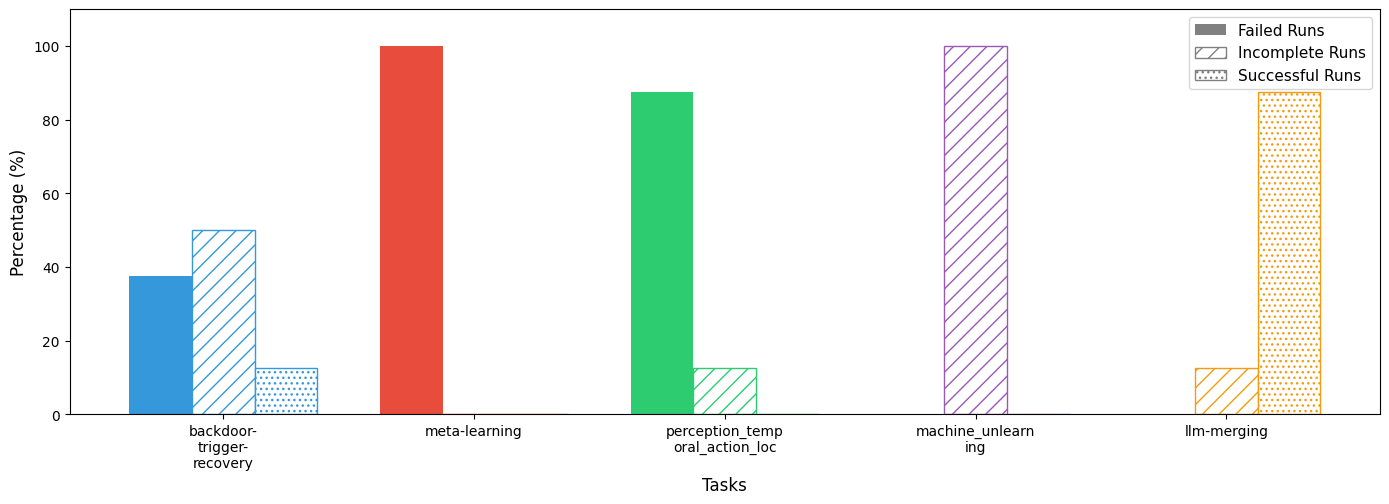

In [36]:
# Get unique tasks
tasks = ['backdoor-trigger-recovery', 'meta-learning', 
         'perception_temporal_action_loc', 'machine_unlearning', 'llm-merging']

# Count failed and incomplete runs for each task
failed_counts = failed_df['Category'].value_counts()
incomplete_counts = incomplete_df['Category'].value_counts()

# Create a DataFrame with all tasks (including those with 0 counts)
plot_data = pd.DataFrame({
    'Failed Runs': [failed_counts.get(task, 0) for task in tasks],
    'Incomplete Runs': [incomplete_counts.get(task, 0) for task in tasks]
}, index=tasks)

# Calculate successful runs (8 total runs minus failed and incomplete)
total_runs_per_task = 8
plot_data['Successful Runs'] = total_runs_per_task - plot_data['Failed Runs'] - plot_data['Incomplete Runs']

# Convert counts to percentages
plot_data = plot_data / total_runs_per_task * 100

# Set a color palette with a distinct color for each task
colors = ['#3498db', '#e74c3c', '#2ecc71', '#9b59b6', '#f39c12']  # Blue, Red, Green, Purple, Orange

# Create the plot
plt.figure(figsize=(14, 6))
width = 0.25  # Narrower bars to fit three categories

# Create bars for each task
for i, task in enumerate(tasks):
    # Failed runs - solid color
    plt.bar(i - width, plot_data.loc[task, 'Failed Runs'], 
            width, color=colors[i], label=f'{task} - Failed' if i == 0 else "")
    
    # Incomplete runs - white fill with colored border and diagonal lines
    plt.bar(i, plot_data.loc[task, 'Incomplete Runs'], 
            width, color='white', edgecolor=colors[i], hatch='//', 
            label=f'{task} - Incomplete' if i == 0 else "")
    
    # Successful runs - white fill with colored border and dotted pattern
    plt.bar(i + width, plot_data.loc[task, 'Successful Runs'], 
            width, color='white', edgecolor=colors[i], hatch='...', 
            label=f'{task} - Successful' if i == 0 else "")

# Customize the plot
plt.xlabel('Tasks', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.xticks(range(len(tasks)), [textwrap.fill(task, 15) for task in tasks], rotation=0)
plt.ylim(0, 110)  # Set y-axis limit to 0-110% to give space at the top

# Create a custom legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='gray', label='Failed Runs'),
    Patch(facecolor='white', edgecolor='gray', hatch='//', label='Incomplete Runs'),
    Patch(facecolor='white', edgecolor='gray', hatch='...', label='Successful Runs')
]
plt.legend(handles=legend_elements, fontsize=11, loc='upper right')

plt.tight_layout()

# Add some padding at the bottom for the labels
plt.subplots_adjust(bottom=0.3)

plt.show()